In [45]:
import tensorflow_data_validation as tfdv

from aif360.datasets import StandardDataset
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import experiment_util as util
import models
import random

%matplotlib ipympl
%matplotlib inline

import matplotlib.pyplot as plt
import plot_util as putil



np.random.seed(0)
random.seed(0)

Load datasets, modify it for the experiment and use Framework to examine the dataset.

In [30]:
raw_df=fetch_ucirepo(id=2).data.original

In [31]:
df=raw_df.copy()
df["income"]=df["income"].replace(['<=50K.','>50K.'],['<=50K','>50K'])
df=df.replace(['?'],[np.nan])

In [32]:
stats = tfdv.generate_statistics_from_dataframe(df)
tfdv.visualize_statistics(stats)

From tensorflow data validation, we can see the more than 90% of feature **capital-gain** and **capital-loss** are 0. It can be safely assumed that they are redundant features and can be ignored during training process 

In [33]:
df=df.dropna()
df=df.reset_index()
df=df.drop(["capital-gain","capital-loss","index"],axis=1)

In [34]:
folds_index=np.array_split(df.sample(frac=1).index,5)
eval=util.evaluation(df,"sex","income","Male",folds_index)
result=pd.DataFrame([],columns=util.column)
result.columns.name="Adult"
result

Adult,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference


Scikit-learn data preprocessing

In [35]:
numeric_feautre_names=df.select_dtypes(include=["number"]).columns
categorical_feature_names=df.select_dtypes(include=["object_"]).columns

pre_df=df.copy()

for nc in numeric_feautre_names:
    pre_df[nc]=util.min_max_noramlize(pre_df[nc])   

for cc in categorical_feature_names:
    pre_df[cc]=pd.factorize(pre_df[cc])[0]

In [36]:
result=util.append_Series(result,eval.cross_validation("Random Forest",models.RandomForest,pre_df))
result

Adult,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.132417,0.105252,-0.136581,0.136581,-0.105252,0.19921,-0.19921,-0.005595,0.109995,0.005595,0.136581,0.82168


In [37]:
result=util.append_Series(result,eval.cross_validation("Neural Network",models.NeuralNetwork,pre_df))
result

Adult,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.132417,0.105252,-0.136581,0.136581,-0.105252,0.199210,-0.199210,-0.005595,0.109995,0.005595,0.136581,0.82168
Neural Network,-0.120890,0.094494,-0.344750,0.344750,-0.094494,0.205494,-0.205494,0.076400,0.099807,-0.076400,0.344750,0.81865


In [38]:
result=util.append_Series(result,eval.cross_validation("Gradient Boosting",models.GradientBoost,pre_df))
result

Adult,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.132417,0.105252,-0.136581,0.136581,-0.105252,0.199210,-0.199210,-0.005595,0.109995,0.005595,0.136581,0.821680
Neural Network,-0.120890,0.094494,-0.344750,0.344750,-0.094494,0.205494,-0.205494,0.076400,0.099807,-0.076400,0.344750,0.818650
Gradient Boosting,-0.117519,0.088441,-0.191437,0.191437,-0.088441,0.195743,-0.195743,0.021913,0.100453,-0.021913,0.191437,0.835766


Scikit-learn models with DisparateImpactRemover from AIF360 preprocessing

In [39]:
raw_dataset=StandardDataset(df=df, label_name="income",
                                    favorable_classes=['>50K'],
                                    scores_name="",
                                    protected_attribute_names=['sex'],
                                    privileged_classes=[["Male"]],
                                    categorical_features=['workclass','education','marital-status','occupation', 'relationship',"race","native-country"])

In [40]:
result=util.append_Series(result,eval.cross_validation("Random Forest (DI)",models.DI_RandomForest,raw_dataset))
result

Adult,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.132417,0.105252,-0.136581,0.136581,-0.105252,0.199210,-0.199210,-0.005595,0.109995,0.005595,0.136581,0.821680
Neural Network,-0.120890,0.094494,-0.344750,0.344750,-0.094494,0.205494,-0.205494,0.076400,0.099807,-0.076400,0.344750,0.818650
Gradient Boosting,-0.117519,0.088441,-0.191437,0.191437,-0.088441,0.195743,-0.195743,0.021913,0.100453,-0.021913,0.191437,0.835766
Random Forest (DI),-0.130097,0.053460,-0.107106,0.107106,-0.053460,0.134444,-0.134444,-0.060351,0.132558,0.060351,0.107106,0.819734


In [41]:
result=util.append_Series(result,eval.cross_validation("Neural Network (DI)",models.DI_NeuralNetwork,raw_dataset))
result

Adult,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.132417,0.105252,-0.136581,0.136581,-0.105252,0.199210,-0.199210,-0.005595,0.109995,0.005595,0.136581,0.821680
Neural Network,-0.120890,0.094494,-0.344750,0.344750,-0.094494,0.205494,-0.205494,0.076400,0.099807,-0.076400,0.344750,0.818650
Gradient Boosting,-0.117519,0.088441,-0.191437,0.191437,-0.088441,0.195743,-0.195743,0.021913,0.100453,-0.021913,0.191437,0.835766
Random Forest (DI),-0.130097,0.053460,-0.107106,0.107106,-0.053460,0.134444,-0.134444,-0.060351,0.132558,0.060351,0.107106,0.819734
Neural Network (DI),-0.198904,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.198904,NaN,0.000000,0.752156


The framework output NaN is due to the Neural Network model with Disparate Impact Remover preprocessing will only output Negative predictions.

In [42]:
result=util.append_Series(result,eval.cross_validation("Gradient Boosting (DI)",models.DI_GradientBoost,raw_dataset))
result

Adult,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.132417,0.105252,-0.136581,0.136581,-0.105252,0.199210,-0.199210,-0.005595,0.109995,0.005595,0.136581,0.821680
Neural Network,-0.120890,0.094494,-0.344750,0.344750,-0.094494,0.205494,-0.205494,0.076400,0.099807,-0.076400,0.344750,0.818650
Gradient Boosting,-0.117519,0.088441,-0.191437,0.191437,-0.088441,0.195743,-0.195743,0.021913,0.100453,-0.021913,0.191437,0.835766
Random Forest (DI),-0.130097,0.053460,-0.107106,0.107106,-0.053460,0.134444,-0.134444,-0.060351,0.132558,0.060351,0.107106,0.819734
Neural Network (DI),-0.198904,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.198904,NaN,0.000000,0.752156
Gradient Boosting (DI),-0.115815,0.080628,-0.214297,0.214297,-0.080628,0.188280,-0.188280,0.024197,0.102500,-0.024197,0.214297,0.834749


Since the bias evalutation metrics of Neutral Network with Disparate Impact is invalid, those result will be removed from the analysis of the experiment result

In [43]:
result=result.drop(["Neural Network (DI)"])
result

Adult,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.132417,0.105252,-0.136581,0.136581,-0.105252,0.199210,-0.199210,-0.005595,0.109995,0.005595,0.136581,0.821680
Neural Network,-0.120890,0.094494,-0.344750,0.344750,-0.094494,0.205494,-0.205494,0.076400,0.099807,-0.076400,0.344750,0.818650
Gradient Boosting,-0.117519,0.088441,-0.191437,0.191437,-0.088441,0.195743,-0.195743,0.021913,0.100453,-0.021913,0.191437,0.835766
Random Forest (DI),-0.130097,0.053460,-0.107106,0.107106,-0.053460,0.134444,-0.134444,-0.060351,0.132558,0.060351,0.107106,0.819734
Gradient Boosting (DI),-0.115815,0.080628,-0.214297,0.214297,-0.080628,0.188280,-0.188280,0.024197,0.102500,-0.024197,0.214297,0.834749


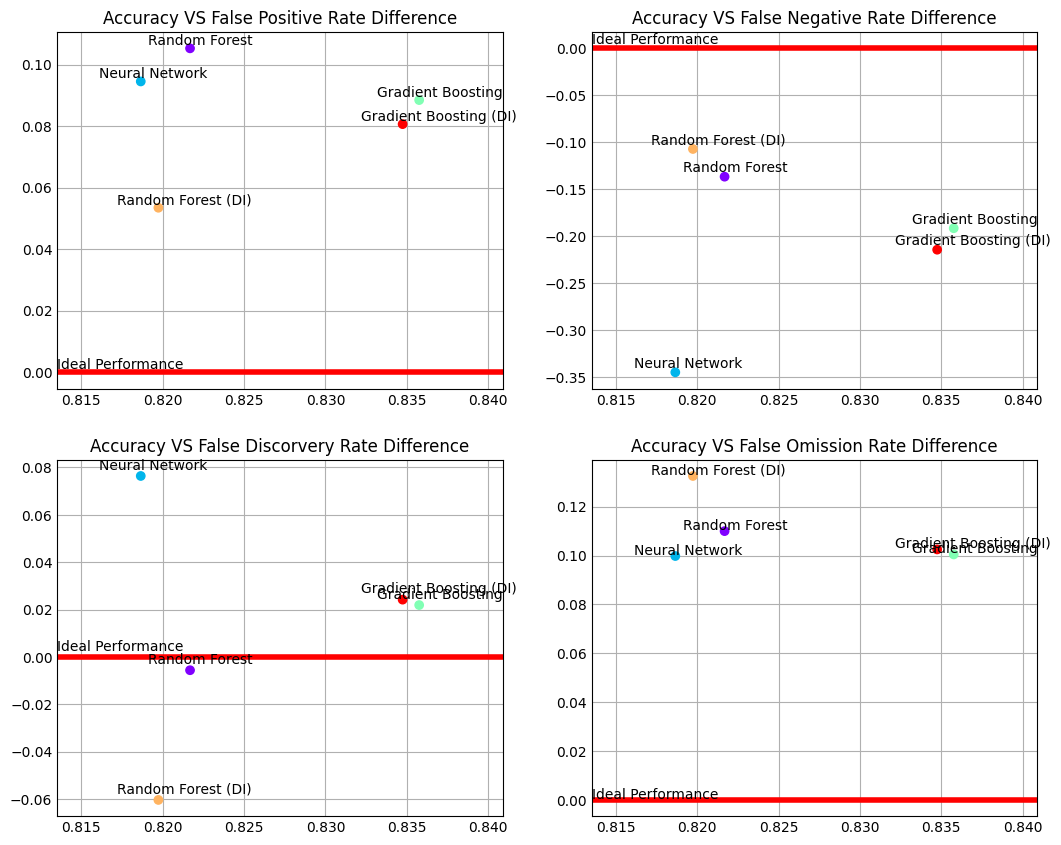

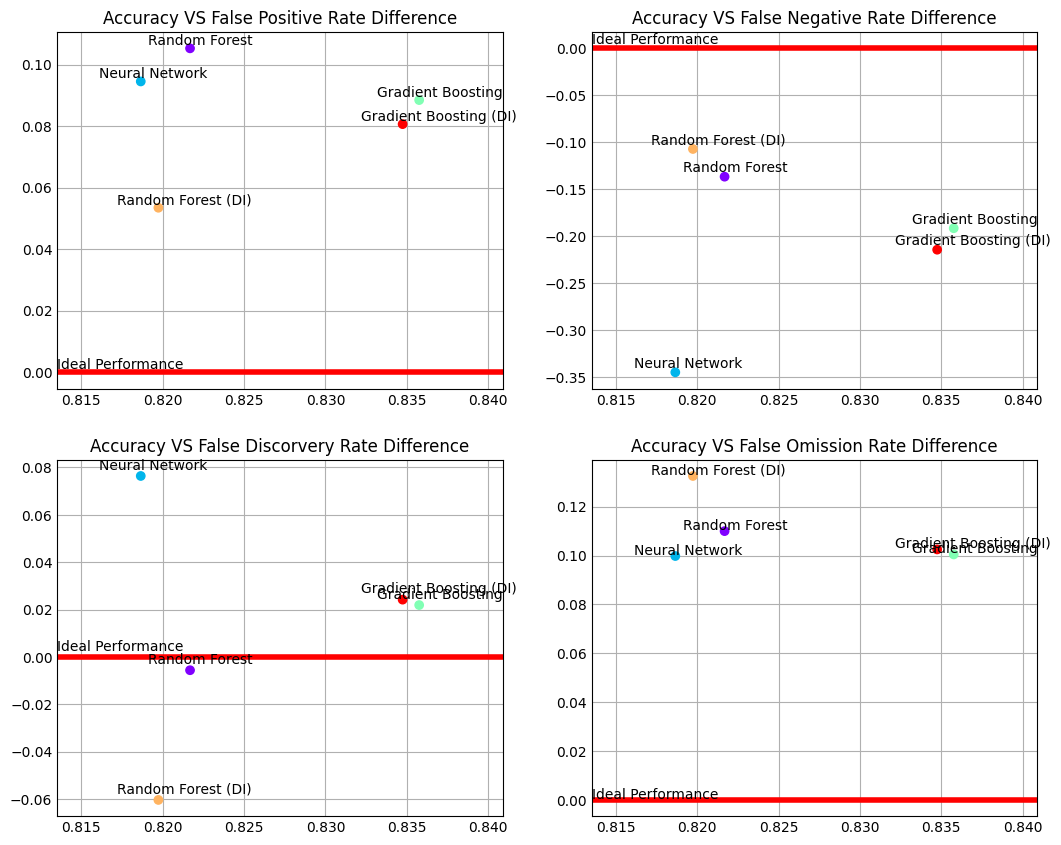

In [46]:
plt.style.use('_mpl-gallery')


# plot
fig, ax = plt.subplots(2,2,figsize=(10,8))

putil.plot_scatter(ax[0][0],result["Accuracy"],result["FPR Difference"],"Accuracy VS False Positive Rate Difference",result.index)
putil.plot_scatter(ax[0][1],result["Accuracy"],result["FNR Difference"],"Accuracy VS False Negative Rate Difference",result.index)
putil.plot_scatter(ax[1][0],result["Accuracy"],result["FDR Difference"],"Accuracy VS False Discorvery Rate Difference",result.index)
putil.plot_scatter(ax[1][1],result["Accuracy"],result["FOR Difference"],"Accuracy VS False Omission Rate Difference",result.index)

plt.show()